# ODE tests
March 2, 2016 (M. Lamoureux)

We are using the book Python for Scientists by John M. Stewart. 

This is some basic tests of an ODE numerical solver, to test its accuracy, and to consider whether our asymptotic analysis of a pendulum is any good.

We start out by loading the important numerical packages. ODEint is based on _lsoda_, a Fortran package from Lawrence Livermore Labs. 

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint # This is the numerical solver

We start with a second order linear equation, that has the usual harmonic oscillator solutions.
$$ y''(t) + \omega^2 y(t) = 0, \qquad y(0) = 1, y'(0) = 0.$$
To put this into the numerical solver, we need to reformulate as a 2 dimensional, first order system:
$$\mathbf{y} = (y,y')^T, \qquad \mathbf{y}'(t) = (y', -\omega^2 y)^T.$$
Here is a simple code snippet that solves the problem numerically. 

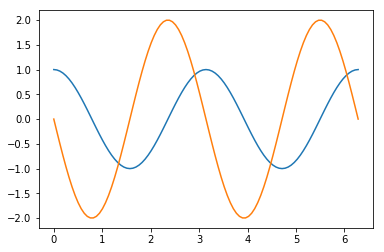

In [23]:
def rhs(Y,t,omega):  # this is the function of the right hand side of the ODE
    y,ydot = Y
    return ydot,-omega*omega*y

t_arr=np.linspace(0,2*np.pi,101)
y_init =[1,0]
omega = 2.0
y_arr=odeint(rhs,y_init,t_arr, args=(omega,))
y,ydot = y_arr[:,0],y_arr[:,1]
plt.ion()
plt.plot(t_arr,y,t_arr,ydot);

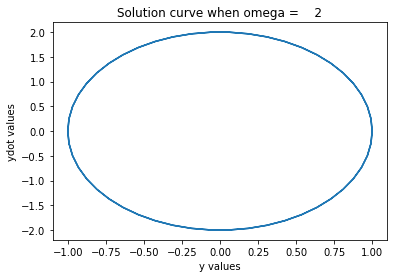

In [24]:
# Let's draw a phase portrait, plotting y and ydot together
plt.plot(y,ydot)
plt.title("Solution curve when omega = %4g" % omega)
plt.xlabel("y values")
plt.ylabel("ydot values");

Now, I would like to test how accurate this numerical code is, by comparing the exact solution with the numerical solution. The exact solution is given by the initial values of y_init, and omega, and involves cosines and sines.


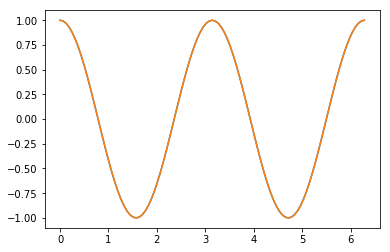

In [25]:
t_arr=np.linspace(0,2*np.pi,101)
y_init =[1,0]
omega = 2.0
y_exact = y_init[0]*np.cos(omega*t_arr) + y_init[1]*np.sin(omega*t_arr)/omega
ydot_exact = -omega*y_init[0]*np.sin(omega*t_arr) + y_init[1]*np.cos(omega*t_arr)
y_arr=odeint(rhs,y_init,t_arr, args=(omega,))
y,ydot = y_arr[:,0],y_arr[:,1]
plt.plot(t_arr,y,t_arr,y_exact);

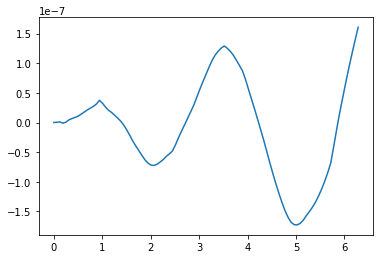

In [26]:
# We plot the difference
plt.plot(t_arr,y-y_exact);

So, in the test I did above, we see an error that oscillates and grows with time, getting to about size 2x 10^(-7). Which is single precision accuray.

Now, apparently ODEint figures out good step sizes on its own. Let's try running the code again, with different number of steps in the t-variable. 



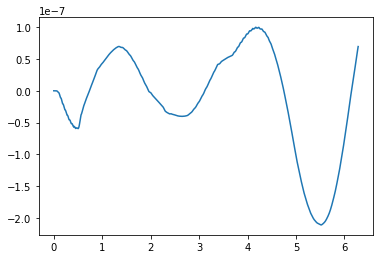

In [27]:
numsteps=1000001  # adjust this parameter
y_init =[1,0]
omega = 2.0
t_arr=np.linspace(0,2*np.pi,numsteps)
y_exact = y_init[0]*np.cos(omega*t_arr) + y_init[1]*np.sin(omega*t_arr)/omega
ydot_exact = -omega*y_init[0]*np.sin(omega*t_arr) + y_init[1]*np.cos(omega*t_arr)
y_arr=odeint(rhs,y_init,t_arr, args=(omega,))
y,ydot = y_arr[:,0],y_arr[:,1]
plt.plot(t_arr,y-y_exact);

Okay, I went up to one million steps, and the error only reduced to about 1.0x10^(-7). Not much of an improvement. 

Let's try another experiment, where we go for a really long time. Say 100 time longer than the example above. 

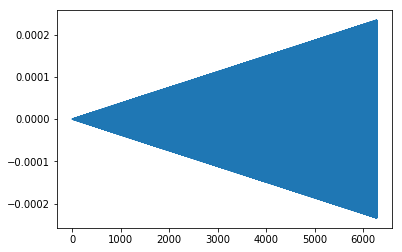

In [28]:
numsteps=100001  # adjust this parameter
y_init =[1,0]
omega = 2.0
t_arr=np.linspace(0,2*1000*np.pi,numsteps)
y_exact = y_init[0]*np.cos(omega*t_arr) + y_init[1]*np.sin(omega*t_arr)/omega
ydot_exact = -omega*y_init[0]*np.sin(omega*t_arr) + y_init[1]*np.cos(omega*t_arr)
y_arr=odeint(rhs,y_init,t_arr, args=(omega,))
y,ydot = y_arr[:,0],y_arr[:,1]
plt.plot(t_arr,y-y_exact);

Interesting. My little test show the error grow linearly with the length of time. In the first time, 2x10^(-7). For 10 times longer, 2x10^(-6). For 100 times longer, 2x10^(-5). And so one. 

A more subtle question: are these amplitude errors, or phase errors, or perhaps a combination?



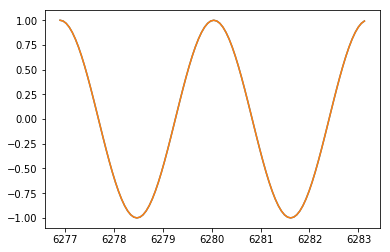

In [29]:
p1=np.size(t_arr)-1
p0=p1-100
plt.plot(t_arr[p0:p1],y[p0:p1],t_arr[p0:p1],y_exact[p0:p1]);

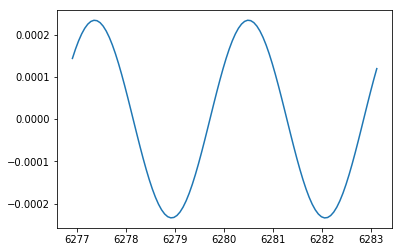

In [30]:
plt.plot(t_arr[p0:p1],y[p0:p1]-y_exact[p0:p1]);

Ah ha! This looks like the negative derivative of the solution, which indicates we have a phase error. Because with phase error, we see the difference
$$\cos(t + \delta) - \cos(t) \approx -\delta\cdot \sin(t)$$
while with an amplitude error, we would see
$$(1+\delta)\cos(t) - \cos(t) \approx \delta\cdot \cos(t).$$

Let's plot the soluton and the error difference, to see if the derivative zeros line up with peaks. 

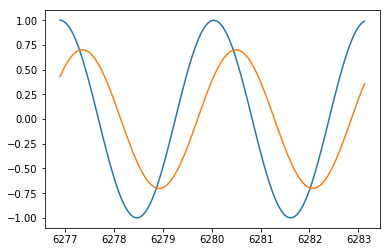

In [13]:
plt.plot(t_arr[p0:p1],y_exact[p0:p1],t_arr[p0:p1],3000*(y[p0:p1]-y_exact[p0:p1]));

Looking at the above, we see they don't quite line up. So a bit of phase error, a bit of amplitude error. 

## The non-linear pendulum
Well, it's not to hard to generalize this stuff to the non-linear pendulum, where the restoring force has a sin(t) in it. We want to observe the period changes with the initial conditions (a bigger swing has a longer period). 

The differential equation is 
$$ y''(t) + \omega^2 \sin(y(t)) = 0, \qquad y(0) = \epsilon, y'(0) = 0.$$
To put this into the numerical solver, we need to reformulate as a 2 dimensional, first order system:
$$\mathbf{y} = (y,y')^T, \qquad \mathbf{y}'(t) = (y', -\omega^2 \sin(y))^T.$$
Here is a simple code snippet that solves the problem numerically. 

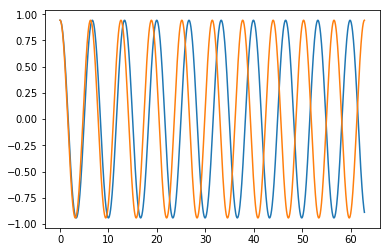

In [36]:
def rhsSIN(Y,t,omega):  # this is the function of the right hand side of the ODE
    y,ydot = Y
    return ydot,-omega*omega*np.sin(y)

omega = 1.0   # basic frequency
epsilon = .3*np.pi # initial displacement, in radians
t_arr=np.linspace(0,2*10*np.pi,1001)
y_init =[epsilon,.01]

# we first set up the exact solution for the linear oscillator
y_exact = y_init[0]*np.cos(omega*t_arr) + y_init[1]*np.sin(omega*t_arr)/omega
ydot_exact = -omega*y_init[0]*np.sin(omega*t_arr) + y_init[1]*np.cos(omega*t_arr)
y_arr=odeint(rhsSIN,y_init,t_arr, args=(omega,))
y,ydot = y_arr[:,0],y_arr[:,1]
plt.ion()
plt.plot(t_arr,y,t_arr,y_exact);

With epsilon = 0.1 (radians, which is about 5.7 degrees), it is hard to see a period shift. With epsilon = 0.5 (radians, which just under 30 degrees), we clearly see a shift after ten cycles of oscillation. 

How big is the shift? Can we figure this out easily with numerics? And how does it compare with the estimate given by the Poincare-Lindstedt method?

## The Lorenz equation
You've probably heard of the butterfly effect (it's even a movie). The idea is that weather can demonstrate chaotic behaviour, so that the flap of a butterfly wing in Brazil could eventually result in a tornado in Alabama. 

Lorenz was studying a simplified model for weather, given by a system of three simple ODEs:
$$x' = \sigma(y-x), \quad y'=\rho x - y - xz, \quad z' = xy - \beta z$$
where $x,y,z$ are functions of time, and $\sigma, \rho,\beta$ are fixed constants. 

When $\rho$ is small, the behaviour is quite predictable. But when $\rho gets better than about 24.7, you get strange, aperiodic behaviour. 

Here is some code that demonstrates the behaviour. We also include 3D plots


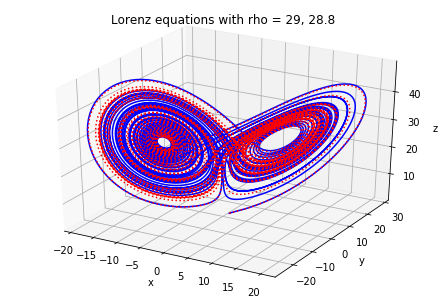

In [37]:
def rhsLZ(u,t,beta,rho,sigma):
    x,y,z = u
    return [sigma*(y-x), rho*x-y-x*z, x*y-beta*z]

sigma = 10.0
beta = 8.0/3.0
rho1 = 29.0
rho2 = 28.8  # two close values for rho give two very different curves

u01=[1.0,1.0,1.0]
u02=[1.0,1.0,1.0]

t=np.linspace(0.0,50.0,10001)
u1=odeint(rhsLZ,u01,t,args=(beta,rho1,sigma))
u2=odeint(rhsLZ,u02,t,args=(beta,rho2,sigma))

x1,y1,z1=u1[:,0],u1[:,1],u1[:,2]
x2,y2,z2=u2[:,0],u2[:,1],u2[:,2]

from mpl_toolkits.mplot3d import Axes3D

plt.ion()
fig=plt.figure()
ax=Axes3D(fig)
ax.plot(x1,y1,z1,'b-')
ax.plot(x2,y2,z2,'r:')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz equations with rho = %g, %g' % (rho1,rho2));


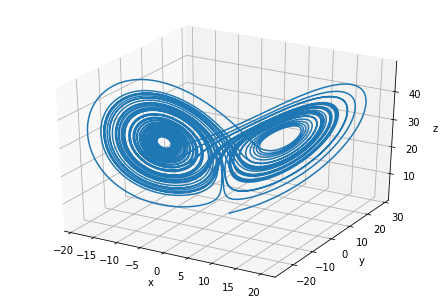

In [16]:
fig=plt.figure()
ax=Axes3D(fig)
ax.plot(x1,y1,z1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


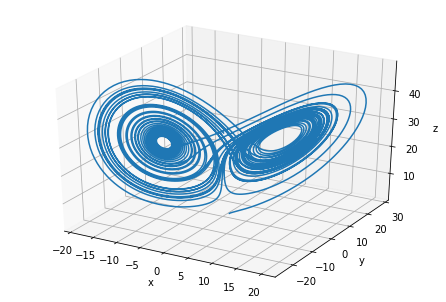

In [17]:
fig=plt.figure()
ax=Axes3D(fig)
ax.plot(x2,y2,z2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


You should play around with the time interval (in the definition of varible t) to observe the predictable, followed by chaotic behaviour. ANd play with other parameters. 

## van der Pol equation
This equation is used as a testbed for numerical software. It is nonlinear, and collapses to a periodic orbit very quickly. We can include information about the Jacobian, the derivative of the vector function $\mathbf{f}$ in the ODE system $\mathbf{y}' = \mathbf{f}(\mathbf{y},t)$, into the ODE solver, to help it choose appropriate step sizes and reduce errors. 

The van der Pol equation is this:
$$y'' - \mu(1-y^2)y' + y = 0$$
with the usual initial conditons for $y(0), y'(0)$. In vector form, we write
$$\mathbf{y} = (y,y')^T, \qquad \mathbf{f}(\mathbf{y}) = (y', \mu(1-y^2)y' - y)^T.$$
The Jacobian is a 2x2 matrix of partial derivatives for $\mathbf{f}$, which is
$$\mathbf{J}(\mathbf{y}) =
\left(
\begin{array}{cc}
0 & 1 \\
-2\mu y * y' -1 & \mu(1-y^2)
\end{array}
\right)
$$

We set up the code as follows:



mu = 100, number of Jacobian calls is 120


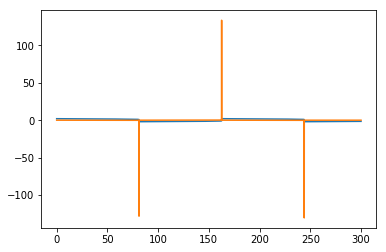

In [20]:
def rhsVDP(y,t,mu):
    return [ y[1], mu*(1-y[0]**2)*y[1] - y[0]]

def jac(y,t,mu):
    return [ [0,1], [-2*mu*y[0]*y[1]-1, mu*(1-y[0]**2)]]

mu=100
t=np.linspace(0,300,10001)
y0=np.array([2.0,0.0])
y,info=odeint(rhsVDP,y0,t,args=(mu,),Dfun=jac,full_output=True)

print("mu = %g, number of Jacobian calls is %d" % (mu, info['nje'][-1]))

plt.plot(t,y);

Try playing with the mu parameter. mu=0 gives the harmonic oscillator. mu=10 starts giving pointy spikes. For mu big, you might want to increase the range of to values, from [0,30] to a larger interval like [0,100]. Etc. 


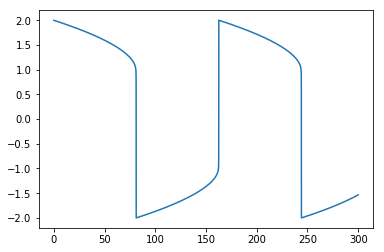

In [21]:
plt.plot(t,y[:,0]);